In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps

from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib import ticker
from matplotlib.colors import TwoSlopeNorm

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [8]:
def WeightedMean(var):
    weights = np.cos(np.deg2rad(var.lat))
    if len(var.shape) >= 2:
        return var.weighted(weights).mean(dim=('lat', 'lon'))
    else:
        return var.weighted(weights).mean("lat")

def plume_locs(ax):
        macsp = xr.open_dataset('../datasets/MAC-SP.nc')

        transform = ccrs.PlateCarree()._as_mpl_transform(ax)
        
        for iplume in macsp.plume_number:
            ax.plot(
                macsp.plume_lon.sel(plume_number=iplume),
                macsp.plume_lat.sel(plume_number=iplume),
                marker="^",
                color="darkorange",
                #markerfacecolor='none',
                markersize=3,
                transform=transform,
            )
class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        v_ext = np.max( [ np.abs(self.vmin), np.abs(self.vmax) ] )
        x, y = [-v_ext, self.midpoint, v_ext], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
norm = MidpointNormalize( midpoint = 0 )

In [9]:
def effect_map(ax, effect, type, year, sub):
    data = xr.open_dataset(f'~/documents/misu/paper_aerosols/datasets/historical_simple-plumes_yearmean.nc').squeeze().isel(time=year-1850)

    if type == 'all-sky':
        r = 'rad0'

    elif type == 'clear-sky':
        r = 'raf0'
    
    if effect == 'total':
        forcing = data[f'dR_sp_s{r}'] + data[f'dR_sp_t{r}']
        title = 'Total Aerosol Radiative Forcing'
    elif effect == 'direct':
        forcing = data[f'dR_spd_s{r}'] + data[f'dR_spd_t{r}']
        title = 'Aerosol Direct Effect'
    elif effect == 'indirect':
        forcing = data[f'dR_spi_s{r}'] + data[f'dR_spi_t{r}']
        title = 'Aerosol Indirect Effect'
    
    if type == 'clear-sky':
        title = 'Clear-sky Aerosol Radiative Forcing'

    

    var = forcing
    lon = var.coords['lon']
    lon_idx = var.dims.index('lon')
    wrap_var, wrap_lon = add_cyclic_point(var.values, coord=lon, axis=lon_idx)

    pc = ax.contourf(wrap_lon,
        var.lat,
        wrap_var,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        #levels= [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2],
        levels= np.linspace(-3, 3, 16),
        #vmin=-5, vmax=2,
        #norm=norm,
        #s=100,
        extend="both",
    )
    axins = inset_axes(ax, width='100%', height='10%', loc="lower center", borderpad=-2)

    cb = plt.colorbar(pc, cax=axins, ax=ax, orientation='horizontal', pad=0.04)
    cb.set_label(label=r'Radiative Forcing [Wm$^{-1}$]', size=10)

    ax.coastlines()
    ax.annotate(r'$\overline{dR}$ = '+'${:.3f}$'.format(WeightedMean(var)),
                [0.05, 0.3], xycoords="axes fraction", fontsize=10)
    
    ax.annotate(sub, [-0.05, 1.05], xycoords="axes fraction", fontsize=13)
    
    ax.set_title(title, fontsize=13)   

    return 0 

In [10]:
def cldcov(ax, year, sub):

    data = xr.open_dataset(f'~/documents/misu/paper_aerosols/datasets/historical_simple-plumes_yearmean.nc').squeeze().isel(time=year-1850)

    var = data.aclcov
    lon = var.coords['lon']
    lon_idx = var.dims.index('lon')
    wrap_var, wrap_lon = add_cyclic_point(var.values, coord=lon, axis=lon_idx)

    #cmap = mcolors.LinearSegmentedColormap.from_list('diverging_cmap', ['#00008B', '#FFFFFF', '#990000'])
    pc = ax.contourf(wrap_lon,
        var.lat,
        wrap_var,
        transform=ccrs.PlateCarree(),
        cmap='YlGnBu',
        #cmap='PuBu',
        levels= np.linspace(0, 1, 11), #np.linspace(Nmin, Nmax, 17),
        #extend="both",
    )
    ax.coastlines()

    axins = inset_axes(ax, width='100%', height='10%', loc="lower center", borderpad=-2)

    cb = plt.colorbar(pc, cax=axins, ax=ax, orientation='horizontal', pad=0.04)
    cb.set_label(label='Fraction', size=10)
    
    ax.set_title('Cloud Cover Fraction', fontsize=13)
    ax.annotate(sub, [-0.05, 1.05], xycoords="axes fraction", fontsize=13)

    return 0

In [11]:
def aod(ax, year, sub):
    data = xr.open_dataset(f'~/documents/misu/paper_aerosols/datasets/historical_simple-plumes_yearmean.nc').squeeze().isel(time=year-1850)

    var = data.aod_sp
    lon = var.coords['lon']
    lon_idx = var.dims.index('lon')
    wrap_var, wrap_lon = add_cyclic_point(var.values, coord=lon, axis=lon_idx)
    formatter = ticker.FormatStrFormatter('%.2f')

    #level = [0, 0.01, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45]
    level = [0, 0.01, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.38]
    pc = ax.contourf(wrap_lon,
        var.lat,
        wrap_var,
        transform=ccrs.PlateCarree(),
        cmap='Purples',
        levels= level,
        #locator=ticker.LogLocator()
        extend='max',
    )
    C = ax.contour(wrap_lon,
        var.lat,
        wrap_var,
        transform=ccrs.PlateCarree(),
        colors='black',
        levels= level,
        #alpha=0.8,
        linewidths=.4,
        extend='max'
    )
    cont = ax.contour(wrap_lon,
        var.lat,
        wrap_var,
        transform=ccrs.PlateCarree(),
        levels=[0.0025], colors='black', linewidths=0.4, linestyles='--')
    ax.coastlines()

    axins = inset_axes(ax, width='100%', height='10%', loc='lower center', borderpad=-2)
    cb = plt.colorbar(pc, cax=axins, ax=ax, orientation='horizontal', pad=0.04, ticks=level)
    cb2 = plt.colorbar(C, cax=axins, ax=ax, orientation='horizontal', pad=0.04, ticks=level)
    cb.add_lines(cont)
    cb.lines[-1].set_linestyles(cont.linestyles)

    def custom_formatter(x, pos):
        if x == 0.002:
            return '0.002%'
        elif x == 0.00:
            return '0%'
        return formatter(x, pos)
    cb.ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))

    ax.annotate(r'$\overline{AOD}$ = '+'${:.3f}$'.format(WeightedMean(var)),
            [0.05, 0.3], xycoords="axes fraction", fontsize=10)
    
    
    cb.set_label(label='Aerosol Optical Depth', size=10)
    ax.set_title('Column Simple-Plumes AOD at 550nm', fontsize=13)
    ax.annotate(sub, [-0.05, 1.05], xycoords="axes fraction", fontsize=13)

    return 0


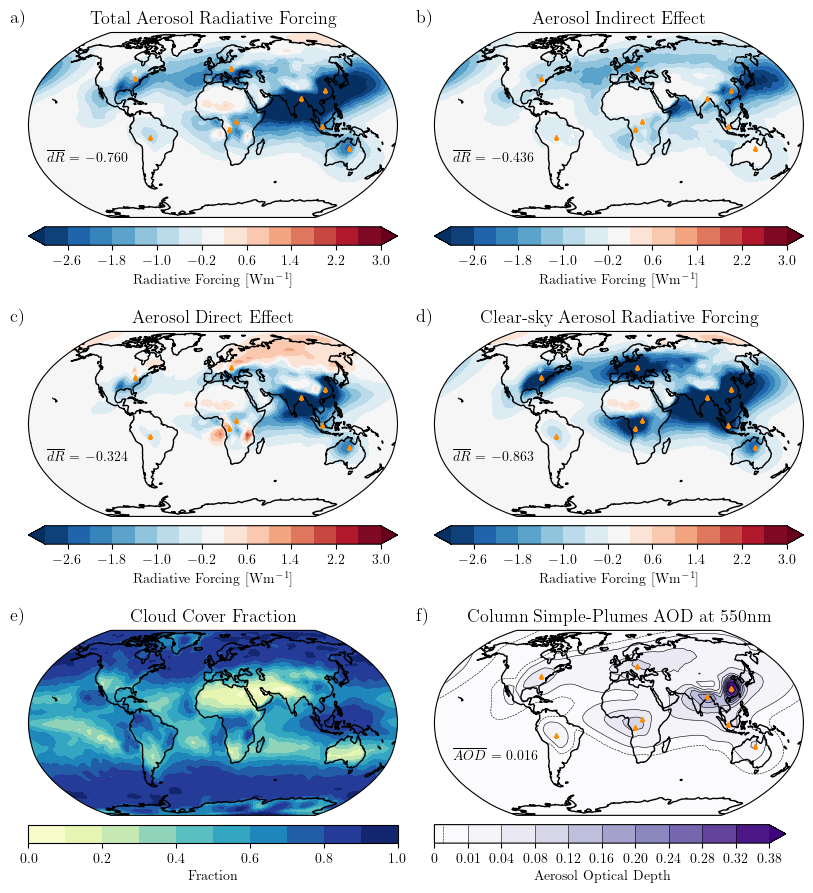

In [12]:
def main():
    year = 2005
    central_longitude = 0
    projectionStyle = ccrs.Robinson(central_longitude=central_longitude)
    fig, ax = plt.subplots(3,2, subplot_kw=dict(projection=projectionStyle))

    effect_map(ax[0,0], 'total', 'all-sky', year, 'a)')
    effect_map(ax[0,1], 'indirect', 'all-sky', year, 'b)')
    effect_map(ax[1,0], 'direct', 'all-sky', year, 'c)')
    effect_map(ax[1,1], 'direct', 'clear-sky', year, 'd)')
    
    cldcov(ax[2,0], year, 'e)')
    aod(ax[2,1], year, 'f)')

    for ax in [
        ax[0,0],
        ax[0,1],
        ax[1,0],
        ax[1,1],
        ax[2,1],
        ]:
            plume_locs(ax)

    #fig.delaxes(ax[2, 1])                      
    fig = plt.gcf()
    fig.set_size_inches(10, 11)
    plt.subplots_adjust(wspace=0.1)
    #plt.tight_layout()

    plt.savefig(f'/home/anthe/documents/misu/paper_aerosols/figures/maps_multi-plot_{year}.pdf', bbox_inches='tight')

    return 0

if __name__ == "__main__":
    main()
